In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
%matplotlib qt5
from astropy.io import fits
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.io import readsav
from scipy import interpolate, ndimage

### Setting matplotlib parameters ###
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.plot(); plt.close();

matplotlib.rcParams['figure.figsize'] = (15,10)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24})
### ----------------------------- ###

In [2]:
# # Defining Functions

def get_dark_subtracted_frame(frame_index, filenames):
    hdul = fits.open(filenames[frame_index])
    frame = hdul[0].data-dark
    frame_header = hdul[0].header
    exp_time = float(hdul[0].header['EXPTIME'])
    n_frames = int(hdul[0].header['CADENCE']/exp_time)
    exp_time = exp_time*n_frames if hdul[0].header['FRAMEBIN'] == 'Yes' else exp_time
    frame = frame/exp_time
    return frame

def get_dark_and_background_subtracted_frame(frame_index, filenames):
    noisy_frame = get_dark_subtracted_frame(frame_index, filenames)
    denoised_frame = np.zeros_like(noisy_frame)
    denoised_frame[:,0:sz[1]//2]= noisy_frame[:,0:sz[1]//2]-np.mean(noisy_frame[:,630:670])
    denoised_frame[:,sz[1]//2:]= noisy_frame[:,sz[1]//2:]-np.mean(noisy_frame[:,1700:1740])
    return denoised_frame

def get_spatial_image(wav):
    img = np.squeeze(shift_corr_spectral_cube[:,:,wav])
    return img

def get_spectral_image(posx):
    simg  = np.squeeze(shift_corr_spectral_cube[:,posx,:])
    return simg

def get_profiles(posy,posx):
    pback = np.squeeze(shift_corr_spectral_cube[posy,posx,:])
    return pback    

In [3]:
# # Loading Data

filenames = glob.glob('Data/20250813/VS1_T25_1190_002570_20250813_*.fits')
filenames = np.sort(filenames)
num_steps = int(len(filenames))
print(f'There are {np.shape(filenames)[0]} files available for the given observation.')
dark = fits.getdata('Spec1_ground_dark_exp_2sec.fits')

There are 103 files available for the given observation.


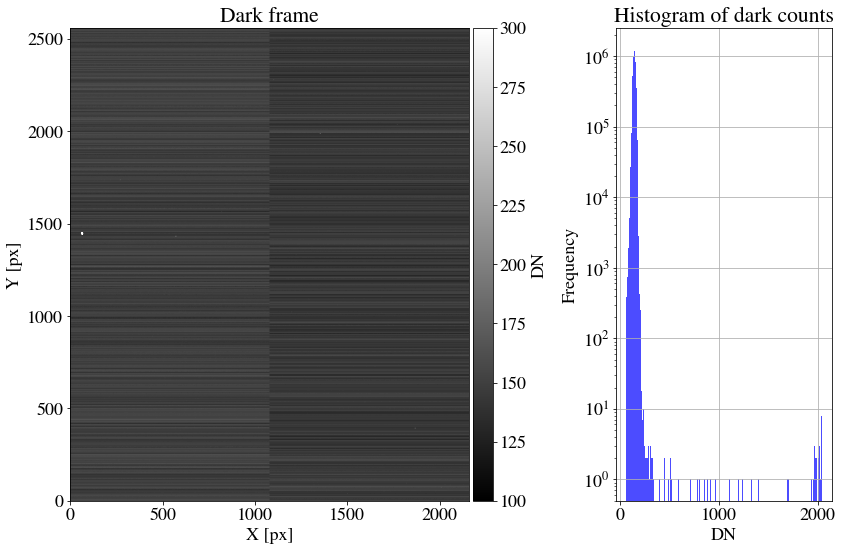

In [4]:
# # Visualizing Data

# ## Dark frame
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 18})

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

ax_img = fig.add_subplot(gs[0])
im = ax_img.imshow(dark, cmap='gray', origin='lower', vmin=100, vmax=300)

divider = make_axes_locatable(ax_img)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
ax_img.set_title('Dark frame')
ax_img.set_xlabel('X [px]'); ax_img.set_ylabel('Y [px]')
cbar.set_label('DN', rotation=90, labelpad=5)

ax_hist = fig.add_subplot(gs[1])
hist = ax_hist.hist(dark.flatten(), bins=256, color='blue', alpha=0.7)
ax_hist.grid()
ax_hist.set_yscale('log')
ax_hist.set_title('Histogram of dark counts')
ax_hist.set_xlabel('DN')
ax_hist.set_ylabel('Frequency')

fig.tight_layout()

plt.show()


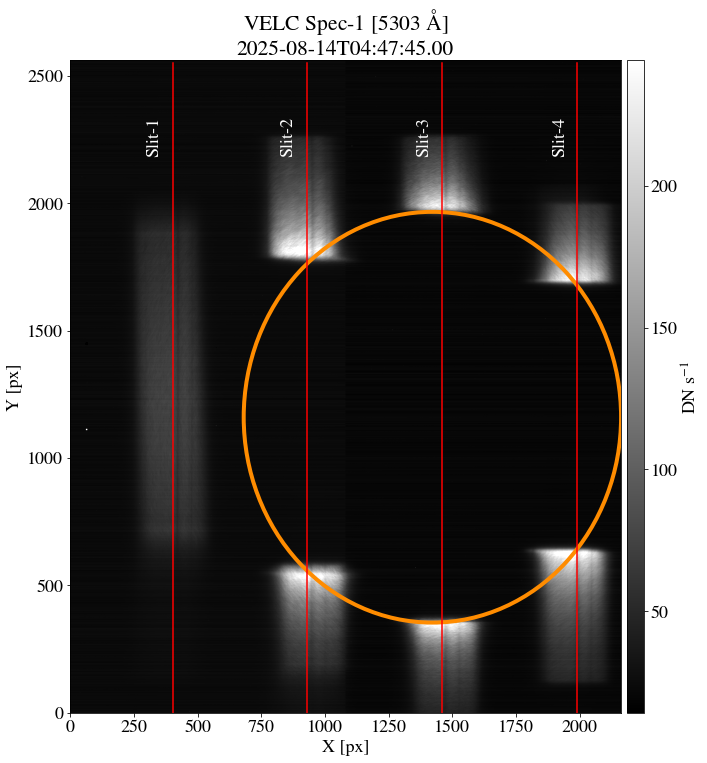

In [5]:
# ## Sample raster scan frame 

file_index = 11

hdul = fits.open(filenames[file_index])
frame = hdul[0].data-dark
frame_header = hdul[0].header

# need to account for frame binning while estimating exposure time
exp_time = float(hdul[0].header['EXPTIME'])
n_frames = int(hdul[0].header['CADENCE']/exp_time)
exp_time = exp_time*n_frames if hdul[0].header['FRAMEBIN'] == 'Yes' else exp_time
frame = frame/exp_time
sz = np.shape(frame)

fig = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 18})
ax = plt.gca()
pim1 = plt.imshow(frame,origin='lower',vmin=np.percentile(frame,0.1),vmax=np.percentile(frame,99.9),cmap='gist_gray')
plt.xlabel('X [px]')
plt.ylabel('Y [px]')
plt.ylim(0,sz[0])
plt.xlim(0,sz[1])
cb=plt.colorbar(pim1,pad=0.01,aspect=40)
cb.set_label(r'DN s$^{-1}$')
ellipse = patches.Ellipse(
        (1195+(51-file_index)*5.66,1160), 
        1481, 
        1612, 
        angle=0, 
        edgecolor='darkorange', 
        facecolor='none', 
        linewidth=4)
ax.add_patch(ellipse)
plt.plot((402,402),(0,2550),color='red')
plt.plot((931,931),(0,2550),color='red')
plt.plot((1460,1460),(0,2550),color='red')
plt.plot((1989,1989),(0,2550),color='red')
plt.text(300,2200,'Slit-1', rotation=90,color='white')
plt.text(825,2200,'Slit-2', rotation=90,color='white')
plt.text(1360,2200,'Slit-3', rotation=90,color='white')
plt.text(1890,2200,'Slit-4', rotation=90,color='white')
plt.title(r'VELC Spec-1 [5303$~\mathrm{\AA}$]'+'\n'+frame_header['date'][0:22])
plt.show()

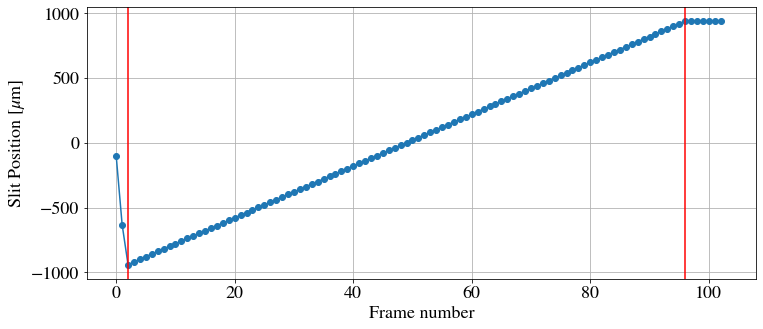

In [6]:
# ## Raster slit positions

NUM_RASTER_STEPS = 94 # 94 frames are required for a complete raster (+- 1.5 R_sun) with 20 micron step size  
slit_pos = np.zeros(num_steps) 
for ii in range(num_steps):
    hdul = fits.open(filenames[ii])
    slit_pos[ii] = hdul[0].header['SLIT_POS']

fig = plt.figure(figsize=(12, 5))
plt.rcParams.update({'font.size': 18})    
plt.plot(slit_pos, 'o-')
plt.plot((2,2),(-1050,1050),color='red')
plt.plot((2+94,2+94),(-1050,1050),color='red')
plt.xlabel('Frame number')
plt.ylabel(r'Slit Position [$\mu$m]')
plt.grid()
plt.xlim(0-5,num_steps+5)
plt.ylim(-1050,1050)
plt.show()

In [7]:
delta_step = slit_pos[1:]-slit_pos[0:-1]
median_delta_step = np.median(delta_step)
steps_indices = np.where((delta_step > median_delta_step-10) & (delta_step < median_delta_step+10))[0]
steps_indices = steps_indices + 1
raster_filenames = filenames[steps_indices[0]:steps_indices[0]+NUM_RASTER_STEPS]
raster_scan_slit_positions = slit_pos[steps_indices[0]:steps_indices[0]+NUM_RASTER_STEPS]
print('Raster scan slit positions (in microns) are: \n', raster_scan_slit_positions)

Raster scan slit positions (in microns) are: 
 [-919.5 -899.  -878.5 -858.5 -838.5 -818.5 -798.5 -778.5 -758.5 -738.5
 -718.5 -698.5 -678.5 -659.  -638.5 -619.  -599.  -578.5 -558.5 -538.5
 -519.  -498.5 -479.  -458.5 -438.5 -418.5 -398.5 -378.5 -358.5 -338.5
 -318.5 -299.  -278.5 -258.5 -238.5 -218.5 -198.5 -178.5 -158.5 -138.5
 -118.5  -98.5  -78.5  -58.5  -38.5  -18.5    1.5   21.5   41.5   61.
   81.5  101.5  121.5  141.5  161.5  181.5  201.   221.   241.5  261.
  281.5  301.5  321.5  341.   361.   381.   401.   421.   441.   461.
  481.   501.   521.   541.   561.   581.   601.5  621.5  641.5  661.5
  681.5  701.5  721.5  741.5  761.   781.5  801.5  821.5  841.   861.5
  881.5  901.5  921.5  941.5]


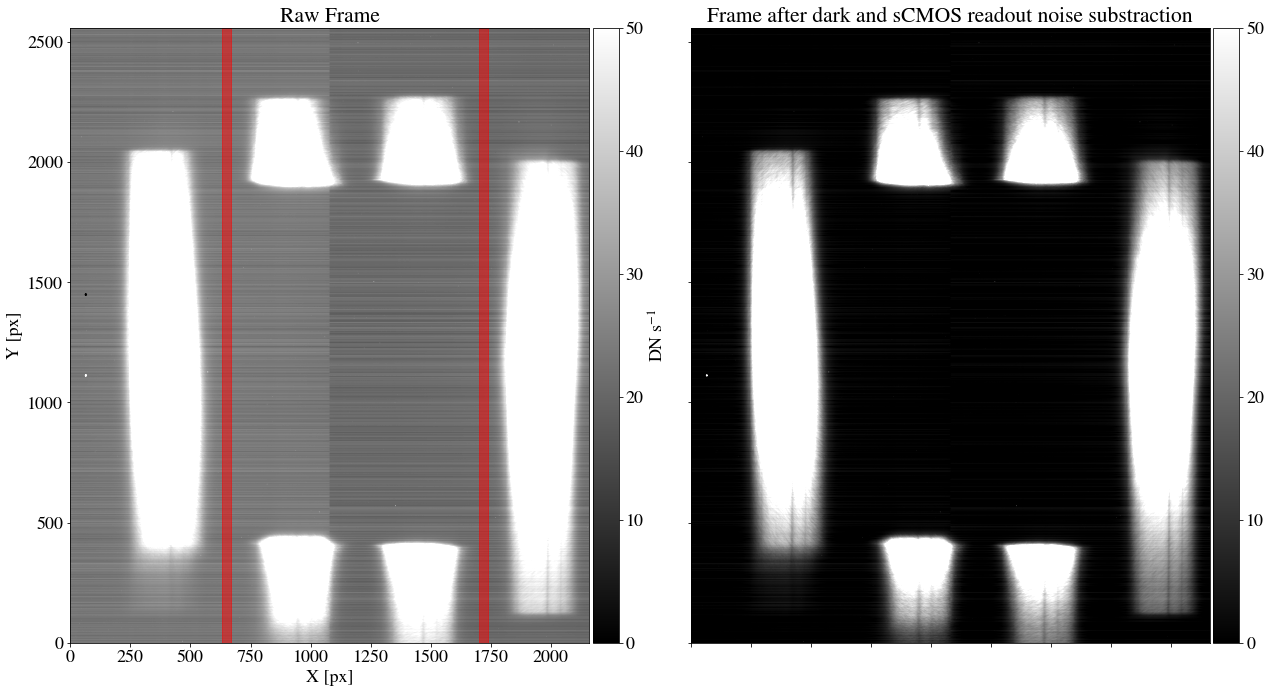

In [8]:
# # Data Processing

# ## Noise/Background subtraction

file_index = 0
noisy_frame = get_dark_subtracted_frame(file_index, filenames)
denoised_frame = np.zeros_like(noisy_frame)
denoised_frame[:,0:sz[1]//2]= noisy_frame[:,0:sz[1]//2]-np.mean(noisy_frame[:,630:670])
denoised_frame[:,sz[1]//2:]= noisy_frame[:,sz[1]//2:]-np.mean(noisy_frame[:,1700:1740])

fig = plt.figure(figsize=(18, 10))
plt.rcParams.update({'font.size': 18})

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])

ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(noisy_frame, cmap='gist_gray', origin='lower', vmin=0, vmax=50)
ax1.axvspan(630,670, alpha=0.5, color='red')
ax1.axvspan(1700,1740, alpha=0.5, color='red')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im1, cax=cax1)
ax1.set_title('Raw Frame')
ax1.set_xlabel('X [px]'); ax1.set_ylabel('Y [px]')
cbar.set_label(r'DN s$^{-1}$', rotation=90, labelpad=5)

ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(denoised_frame, cmap='gist_gray', origin='lower', vmin=0, vmax=50)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im2, cax=cax2)
ax2.set_title('Frame after dark and sCMOS readout noise substraction')
#ax2.set_xlabel('X [px]'); ax2.set_ylabel('Y [px]')
ax2.set_xticklabels([]); ax2.set_yticklabels([])
#cbar.set_label(r'DN s$^{-1}$', rotation=90, labelpad=5)

fig.tight_layout()

plt.show()

In [9]:
# ## Spectral cube generation

frames_stack = np.zeros([sz[0],sz[1],len(raster_filenames)])

for ii in tqdm(range(len(raster_filenames))): 
    frame = get_dark_and_background_subtracted_frame(ii, raster_filenames)
    frames_stack[:,:,ii] = np.flip(frame,1) 

wlm1 = 0
wlm2 = 518
wlm3 = 1040
wlm4 = 1566

num_spec_points = 480 # 480 pixel in X-direction uniformly coveres full spectral range covered by pre-filter  
spectral_cube = np.zeros((np.shape(frames_stack)[0],num_spec_points,np.shape(frames_stack)[2]*4))

for ii in tqdm(range(np.shape(frames_stack)[2])):
    spectral_cube[:,:,ii] = frames_stack[:,wlm4:wlm4+num_spec_points,ii]
    spectral_cube[:,:,ii+np.shape(frames_stack)[2]] = frames_stack[:,wlm3:wlm3+num_spec_points,ii]
    spectral_cube[:,:,ii+np.shape(frames_stack)[2]*2] = frames_stack[:,wlm2:wlm2+num_spec_points,ii]
    spectral_cube[:,:,ii+np.shape(frames_stack)[2]*3] = frames_stack[:,wlm1:wlm1+num_spec_points,ii]
    
spectral_cube = np.transpose(spectral_cube,(0,2,1))
print('Spectral cube as a shape: ', spectral_cube.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:07<00:00, 12.23it/s]

Spectral cube as a shape:  (2560, 376, 480)


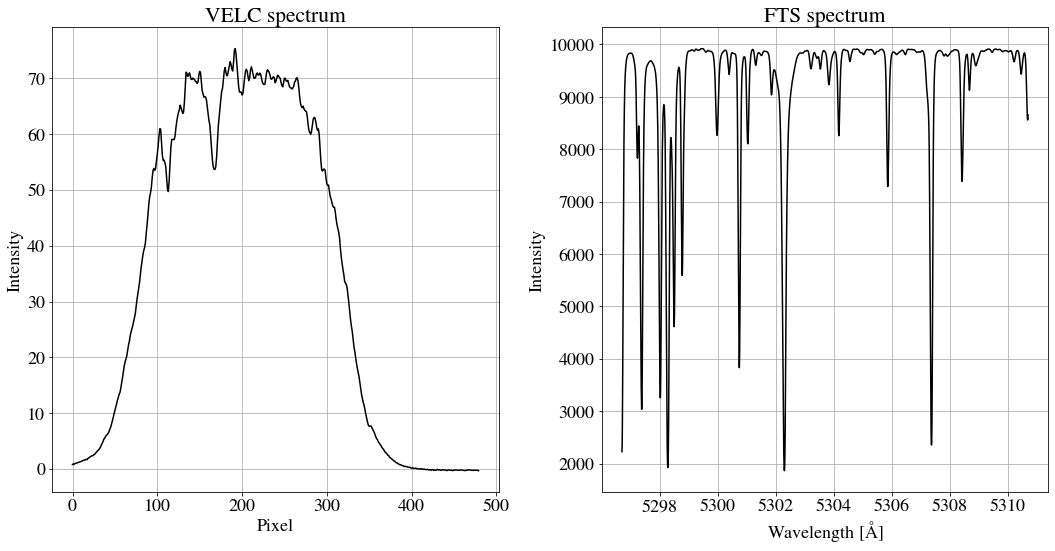

In [10]:
 ## FTS Spectrum and comparison with VELC observation

fl_fts = readsav('5303_fts.sav')
fts_spectrum = fl_fts('aa')[0][0]

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])

ax1 = fig.add_subplot(gs[0])
ax1.plot(np.mean(spectral_cube[1150:1170,20:25,:],axis=(0,1)), c='k')
ax1.set_title('VELC spectrum')
ax1.set_xlabel(r'Pixel'); ax1.set_ylabel('Intensity')
ax1.grid()

ax2 = fig.add_subplot(gs[1])
ax2.plot(fts_spectrum[350:-150,0],fts_spectrum[350:-150,1], c='k')
ax2.set_title('FTS spectrum')
ax2.set_xlabel(r'Wavelength [$\rm{\AA}$]'); ax2.set_ylabel('Intensity')
ax2.grid()
fig.tight_layout()

plt.show()

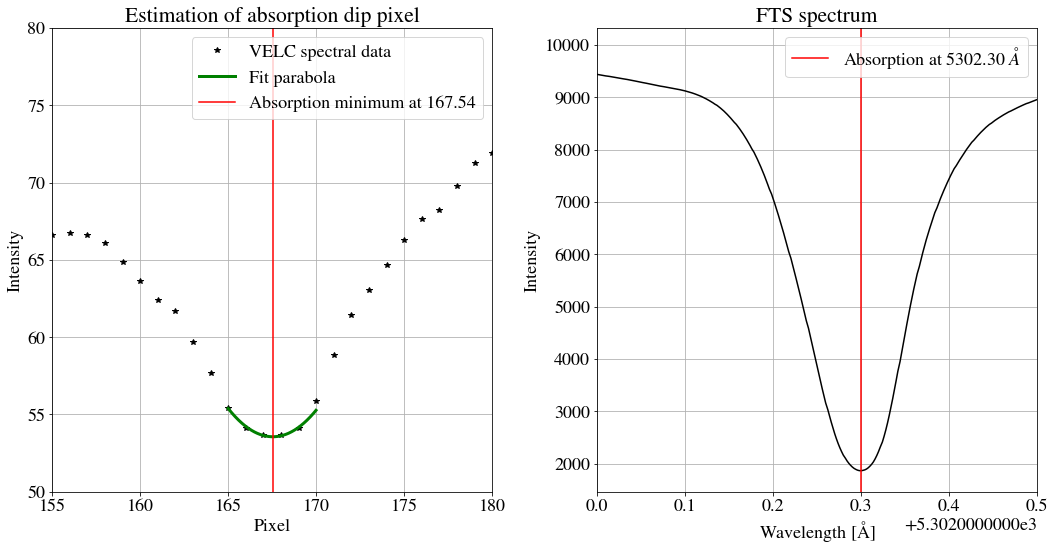

In [11]:
delta_wvl_A = 0.0284 # in angstrom
delta_wvl_mA = 28.4 # in milli-angstrom
xarr = np.arange(0,5,1)
nxarr = np.arange(0,500,1)/100
spatially_binned_spec = np.mean(spectral_cube[1150:1170,20:25,:],axis=(0,1))
absorption_pos = np.argmin(spatially_binned_spec[155:180])

quad_fit_params = np.polyfit(xarr,spatially_binned_spec[155+absorption_pos-3:155+absorption_pos+2], 2)
quad_fit_profile = np.poly1d(quad_fit_params)(nxarr)
wpos = np.argmin(quad_fit_profile)/100 + 165 # 165 is the first index for the 5 data points for fitting parabola 
fts_absorption_dip_index = np.argmin(fts_spectrum[3000:3350,1])
abs_wavelength = fts_spectrum[3000+fts_absorption_dip_index,0]
lam = (np.arange(0,num_spec_points,1)-wpos)*delta_wvl_A+fts_spectrum[3000+fts_absorption_dip_index,0]

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])

ax1 = fig.add_subplot(gs[0])
ax1.plot(np.mean(spectral_cube[1150:1170,20:25,:],axis=(0,1)),'*', c='k', label='VELC spectral data')
ax1.plot(nxarr+165,quad_fit_profile, c='green', linewidth=3, label='Fit parabola')
ax1.axvline(wpos, c='r', label=f'Absorption minimum at {wpos}')
ax1.set_title('Estimation of absorption dip pixel')
ax1.set_xlabel(r'Pixel'); ax1.set_ylabel('Intensity')
ax1.set_xlim(155,180)
ax1.set_ylim(50,80)
ax1.grid(); ax1.legend()

ax2 = fig.add_subplot(gs[1])
ax2.plot(fts_spectrum[:,0],fts_spectrum[:,1], c='k')
plt.axvline(abs_wavelength, c='r', label=f'Absorption at {abs_wavelength:.2f} '+r'$\AA$')
ax2.set_title('FTS spectrum')
ax2.set_xlabel(r'Wavelength [$\mathrm{\AA}$]'); ax2.set_ylabel('Intensity')
ax2.grid(); ax2.legend()
ax2.set_xlim(5302,5302.5)
fig.tight_layout()

plt.show()

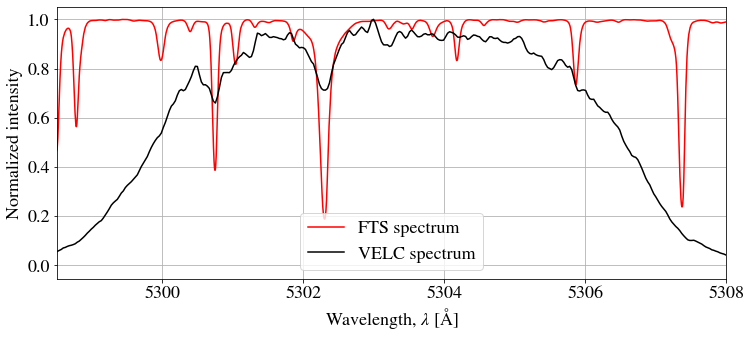

In [12]:
fig = plt.figure(figsize=(12, 5))
plt.plot(fts_spectrum[:,0],fts_spectrum[:,1]/np.max(fts_spectrum[:,1]), c='r', label='FTS spectrum')
plt.plot(lam,spatially_binned_spec/np.max(spatially_binned_spec), c='k', label='VELC spectrum')
plt.legend(); plt.grid()
plt.xlim(5298.5,5308)
plt.xlabel(r'Wavelength, $\lambda~[\mathrm{\AA}]$')
plt.ylabel('Normalized intensity')
plt.show()

In [13]:
# finding curvature shift in wavelength 

scube_shape = np.shape(spectral_cube)

intensity_threshold = 7 # to mask pixel within ocultor area are are outside coverage of slits. 
                         # The threshold may vary from observation to observation, 
                         # and better determined by visulazing the mask created using the threshold 
intensity_map = np.mean(spectral_cube,axis=2)
background_intensity = np.mean(intensity_map[750:1650,120:275])
mask = np.zeros(intensity_map.shape)
mask[np.where(intensity_map >= intensity_threshold)] = 1
mask[0:1,:] = 0 # Since we are using 3 pixel avarage in the Y-direction (slit-direction),
                # the first row does not have 

# here making it NaN to differentiate between 0-shift from non-availability of data
shift_coarse = np.zeros((scube_shape[0],scube_shape[1]))#*np.nan 
shift_fine = np.zeros((scube_shape[0],scube_shape[1]))#*np.nan

xarr = np.arange(0,9,1)
nxarr = np.arange(0,900,1)/100

for ii in tqdm(range(1,scube_shape[0]-1)):
    for jj in range(scube_shape[1]):
        # 150:200 -> curvature claculation using strongest absorption line  
        loop_profile = np.mean(spectral_cube[ii-1:ii+1,jj,150:200],axis=0)  
        loop_abs_dip_pos = np.argmin(loop_profile)
        shift_coarse[ii,jj] = loop_abs_dip_pos

        if (loop_abs_dip_pos > 8) and (loop_abs_dip_pos < 41): 
            loop_quad_fit_params = np.polyfit(xarr, loop_profile[loop_abs_dip_pos-4:loop_abs_dip_pos+5], 2)
            loop_quad_fit_profile = np.poly1d(quad_fit_params)(nxarr)
            shift_fine[ii,jj] = np.argmin(loop_profile)/100 + shift_coarse[ii,jj]-7 


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2558/2558 [00:37<00:00, 67.78it/s]


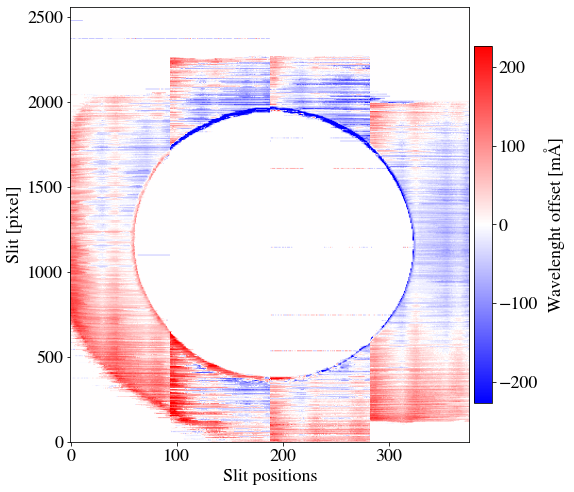

In [14]:
fig = plt.figure(figsize=(8,8))
shift_fine = (shift_fine-np.mean(shift_fine[1150:1170,20:25]))*mask
im1 = plt.imshow(shift_fine*delta_wvl_mA,aspect=0.16,origin='lower',
                 vmin=-8*delta_wvl_mA,vmax=8*delta_wvl_mA,cmap='bwr')
plt.xlabel('Slit positions')
plt.ylabel('Slit [pixel]')
cbar=plt.colorbar(im1,fraction=0.04, pad=0.01)
cbar.ax.set_ylabel(r'Wavelenght offset [$\rm{m\AA}$]')
plt.show()

In [15]:
shift_corr_spectral_cube = np.zeros(scube_shape)

for ii in tqdm(range(scube_shape[0])):
    for jj in range(scube_shape[1]):
        loop_profile = spectral_cube[ii, jj, :]
        shift_corr_spectral_cube[ii,jj,:] = ndimage.shift(loop_profile, -1*shift_fine[ii,jj],order=3, mode='grid-wrap')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2560/2560 [00:44<00:00, 56.94it/s]


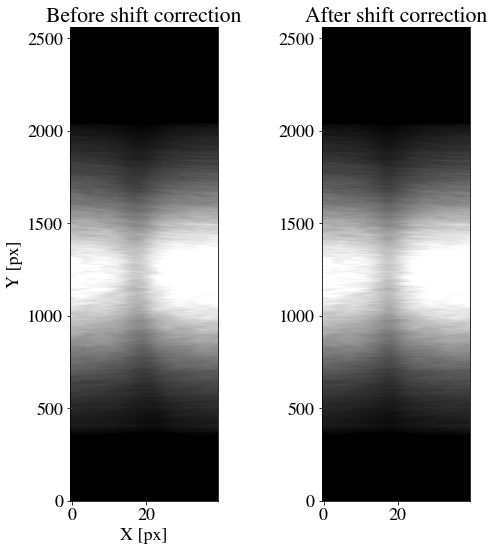

In [22]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(spectral_cube[:,50,150:190], aspect=0.05, cmap='gist_gray', origin='lower', vmin=20, vmax=200)
ax1.set_title('Before shift correction')
ax1.set_xlabel('X [px]'); ax1.set_ylabel('Y [px]')

ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(shift_corr_spectral_cube[:,50,150:190], aspect=0.05, cmap='gist_gray', origin='lower', vmin=20, vmax=200)
ax2.set_title('After shift correction')
#ax2.set_xlabel('X [px]'); ax2.set_ylabel('Y [px]')
#ax2.set_xticklabels([]); ax2.set_yticklabels([])
#cbar.set_label(r'DN s$^{-1}$', rotation=90, labelpad=5)

fig.tight_layout()

plt.show()

In [32]:
%matplotlib qt5

wav = 190
posx = 60
posy = 850

fig = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 12})

gs1 = gridspec.GridSpec(1, 1, figure=fig)
gs2 = gridspec.GridSpec(1, 1, figure=fig)
gs3 = gridspec.GridSpec(1, 1, figure=fig)

gs1.update(left=0.05, right=0.33, bottom=0.1,top=0.9)
gs2.update(left=0.4, right=0.6, bottom=0.1,top=0.9)
gs3.update(left=0.65, right=0.95, bottom=0.2,top=0.8)

#fig, axs = plt.subplots(1, 3, figsize=(24, 8))
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs2[0, 0])
ax3 = fig.add_subplot(gs3[0, 0])

# maybe it would be nice to use variables with appropriate names for 6.5, 1.25, 40, and other numbers used
im00a = ax1.imshow(get_spatial_image(wav), aspect=1,
                      extent = [(-scube_shape[1]/2)*40*1.25/6.5,(scube_shape[1]/2)*40*1.25/6.5,-1160*1.25,(scube_shape[0]-1160)*1.25],
                      vmax=np.percentile(get_spatial_image(wav),99.5),
                      cmap='gist_gray', origin='lower')
im00b, = ax1.plot([(posx-sz[1]/2)*40*1.25/6.5,(posx-sz[1]/2)*40*1.25/6.5],[-1160*1.25,(scube_shape[0]-1160)*1.25],color='red')
im00c, = ax1.plot([-1160*1.25,(scube_shape[0]-1160)*1.25],[(posy-sz[1]/2)*40*1.25/6.5,(posy-sz[1]/2)*40*1.25/6.5],color='red')
ax1.set_ylabel('Solar-Y [arcsec]')
ax1.set_xlabel('Solar-X [arcsec]')

#print(posy,(posy-1160)*1.125))
im01a = ax2.imshow(get_spectral_image(posx), aspect=0.01, 
                      extent = [lam[0],lam[-1],-1160*1.25,(scube_shape[0]-1160)*1.25],
                      vmax=np.percentile(get_spectral_image(posx),99.5),
                      cmap='gist_gray', origin='lower')
im01b, = ax2.plot([lam[0],lam[100]],[(posy-1160)*1.125,(posy-1160)*1.125], color='red')
im01c, = ax2.plot([lam[scube_shape[2]-100],lam[scube_shape[2]-1]],[(posy-1160)*1.125,(posy-1160)*1.125], color='red')
ax2.set_ylabel('Solar-Y [arcsec]')
ax2.set_xlabel(r'[$\rm{\AA}$]')

pcc = get_profiles(posy,posx)

smax = np.max(pcc)
p02d = ax3.axvline(lam[wav], color='gray')
p02c, = ax3.plot(lam,pcc,color='blue')
ax3.set_ylabel(r'DN s$^{-1}$')
ax3.set_xlabel(r'Wavelength [$\rm{\AA}$]')

ax1.set_ylim(-1160*1.25,(scube_shape[0]-1160)*1.25)
ax1.set_xlim((-scube_shape[1]/2)*40*1.25/6.5,(scube_shape[1]/2)*40*1.25/6.5)

ax2.set_ylim(-1160*1.25,(scube_shape[0]-1160)*1.25)
ax2.set_xlim(lam[0],lam[-1])


ax3.set_xlim(lam[0],lam[-1])

xx = [posx]
yy = [posy]

wav_axs = plt.axes([0.125, 0.94, 0.23, 0.03])

def update_wav(val):
    global wav
    wav = val
    dd = get_spatial_image(wav)
    im00a.set_data(dd)
    p02d.set_xdata(lam[wav])
    fig.canvas.draw_idle()
    
def on_click_event(event):
    global posx, posy, xx, yy
    ax = event.inaxes

    if ax is None or ax != ax1:
        return
    
    posx = np.round(event.xdata, 0).astype(np.int64)
    posy = np.round(event.ydata, 0).astype(np.int64)  
    
    xmin = np.asarray((-scube_shape[1]/2)*40*1.25/6.5)
    xmax = np.asarray((scube_shape[1]/2)*40*1.25/6.5)
    ymin = np.asarray(-1160*1.25)
    ymax = np.asarray((scube_shape[0]-1160)*1.25)
    
    xx = int((np.asarray(posx)-xmin)/((xmax-xmin)/scube_shape[1]))
    yy = int((np.asarray(posy)-ymin)/((ymax-ymin)/scube_shape[0]))

    im00b.set_xdata([(np.asarray(xx)-scube_shape[1]/2)*40*1.25/6.5,(np.asarray(xx)-scube_shape[1]/2)*40*1.25/6.5])
    im00c.set_ydata([(np.asarray(yy)-1160)*1.25,(np.asarray(yy)-1160)*1.25])

            
    dd = get_spectral_image(xx)
    im01a.set_data(dd)

    im01b.set_ydata([(np.asarray(yy)-1160)*1.25,(np.asarray(yy)-1160)*1.25])
    im01c.set_ydata([(np.asarray(yy)-1160)*1.25,(np.asarray(yy)-1160)*1.25])

    pc = get_profiles(yy,xx)  
    
    p02c.set_ydata(pc)
    p02d.set_ydata([-20,np.max(pc)+50])
#    p02d.set_xdata(lam[wav])
    
    ax3.set_ylim(-20,np.max(pc)+50)
    fig.canvas.draw_idle()

wave_slider = Slider(
    ax=wav_axs,
    label='Wavelength position',
    valmin=10,
    valmax=470,
    valinit=190,
    valstep=1
)

wave_slider.on_changed(update_wav)

fig.canvas.mpl_connect('button_press_event', on_click_event)

plt.show()